In [3]:
import axelrod as axl
import numpy as np

from axelrod.action import Action
from axelrod.strategies.lookerup import Plays

import opt_mo
import pandas as pd

C, D = Action.C, Action.D

In [4]:
import matplotlib.pyplot as plt
import matplotlib

In [5]:
params = [1, 1, 2]

In [6]:
df_with_g = opt_mo.tools.read_sql_data_frame('../data/with_gambler/main.db')

In [9]:
def get_results(row):
    op_one = row[1:5].values
    op_two = row[5:9].values
    
    opponents = [axl.MemoryOnePlayer(p) for p in [op_one, op_two]]

    ps = row[9:13].values
    best_response = axl.MemoryOnePlayer(ps)
    
    pattern = row[27:-1].values
    
    parameters = Plays(
    self_plays=params[0], op_plays=params[1], op_openings=params[2]
    )
    size = opt_mo.get_lookup_table_size(params)

    initial_action = [
        np.random.choice([C, D], p=[pattern[0], 1 - pattern[0]])
        for _ in range(size)
    ]

    gambler = axl.Gambler(
        pattern=pattern[1:],
        parameters=parameters,
        initial_actions=initial_action,
    )
    
    edges = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    players = [best_response, gambler] + opponents
    
    tournament = axl.Tournament(
        players=players, turns=200, edges=edges, repetitions=50
    )
    results = tournament.play(progress_bar=False)
    
    return results

In [10]:
results = []
for i, row in df_with_g.iterrows():
    result = get_results(row)
    
    results.append(result)

/home/nightwing/anaconda3/envs/opt-mo/lib/python3.6/site-packages/axelrod/result_set.py:413: RuntimeWarning: invalid value encountered in true_divide
  / sum(map(np.array, self.match_lengths))


In [11]:
coop = [result.cooperating_rating[:2] for result in results]
best_coop, gambler_coop = zip(*coop)

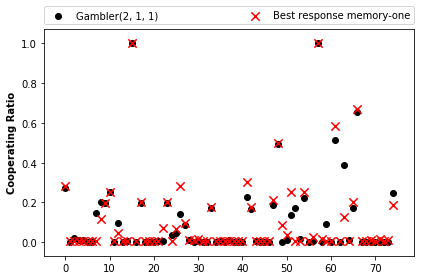

In [12]:
x = len(gambler_coop)
fig, ax = plt.subplots()

plt.scatter(range(x), gambler_coop, label="Gambler(2, 1, 1)", color="black")
plt.scatter(
    range(x),
    best_coop,
    marker="x",
    label="Best response memory-one",
    color="red",
    s=70,
)

plt.ylabel("Cooperating Ratio", fontsize=10, fontweight="bold")
lgd = plt.legend(
    bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
    loc=3,
    ncol=2,
    mode="expand",
    borderaxespad=0.0,
)

fig.tight_layout()

In [13]:
states_columns = ["CC_to_C_rate", "CD_to_C_rate", "DC_to_C_rate", "DD_to_C_rate"]

In [14]:
probabilities = []
for result in results:
    df = pd.DataFrame(result.summarise())
    probabilities.append(df[df['Name'].str.contains('Gambler')][states_columns].values[0])

In [15]:
p_1, p_2, p_3, p_4 = zip(*probabilities)

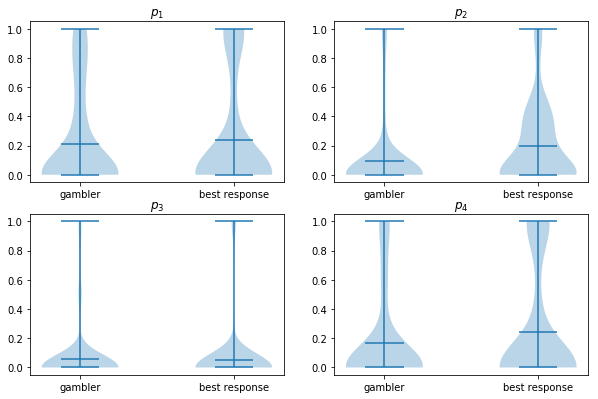

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6.5))

for i, ps in enumerate([p_1, p_2, p_3, p_4]):
    index = (int(i / 2), i % 2)

    axes[index].violinplot(
        [ps, df_with_g["mem_one_p_{}".format(i + 1)]],
        showmeans=True,
    )

    axes[index].set_title(r"$p_{}$".format(i + 1))

    plt.setp(axes[index], xticks=[1, 2], xticklabels=["gambler", "best response"])